In [1]:
from pydantic import BaseModel, Field, field_validator
from typing import List, Optional
import pandas as pd
import yfinance as yf
from enum import Enum, EnumMeta
import re
import matplotlib.pyplot as plt
from scipy.stats import lognorm
#from scipy.optimize import brentq
from datetime import datetime, timedelta
import datetime as dt
import numpy as np

class ImpliedPriceStats(BaseModel):
    params: pd.DataFrame = Field(title='implied price distribution mixture model parameters', description='mixture model parameters for break-even adjusted options implied price probability density')
    mean: float = Field(title='pdf mean', description='break-even adjusted options implied price distribution mean price expectation') 
    stdev: float = Field(title='pdf std-dev', description='break-even adjusted options implied price distribution 1-sigma standard deviation price expectation') 
    median: float = Field(title='pdf median', description='break-even adjusted options implied price distribution median price') 
    lower_95CI: float = Field(title='pdf lower 95 percent confidence interval price', description='break-even adjusted options implied price distribution lower 95 percent confidence interval bound') 
    upper_95CI: float = Field(title='pdf upper 95 percent confidence interval price', description='break-even adjusted options implied price distribution upper 95 percent confidence interval bound') 
    
    class Config:
        arbitrary_types_allowed = True
        
class OptionChain(BaseModel):
    symbol: str = Field(title="ticker symbol", description="underlying asset ticker symbol")
    expiry_date: str = Field(title="Expiry Date", description="Options Chain expiry date")
    current_price: float = Field(title="Current/latest price of underlying asset", description="Current/latest price of underlying asset")
    calls: pd.DataFrame = Field(title="Calls", description="Pandas Dataframe of call options contracts and break-even adjusted implied price + latest asset price derived expected returns")
    puts: pd.DataFrame = Field(title="Puts", description="Pandas Dataframe of put options contracts and break-even adjusted implied price + latest asset price derived expected returns")
    implied_price_stats: ImpliedPriceStats = Field(title="Break-Even Adjusted Options Implied Price Statistics", description="Break-Even Adjusted Options Implied Price Statistics, including pdf and pdf aggragate statistics")
    
    class Config:
        arbitrary_types_allowed = True
        
    @classmethod
    def fetch_and_process(cls, ticker, expiry_date, recency_decay_rate=144., current_price=None, uncertainty_factor=1/np.sqrt(2.)):
        if isinstance(ticker,str):
            symbol = ticker
            ticker = yf.Ticker(ticker)
        else:
            symbol = ticker.ticker

        if current_price==None:
            current_price = ticker.history(period="1d")['Close'][0]
        
        option_chain = ticker.option_chain(expiry_date)
        calls = option_chain.calls.copy()
        assert len(calls)>0 and calls['volume'].sum()>0, expiry_date + 'call options data corrupted... skipping option chain data processing'
        calls = calls[(calls['ask']>0) & (calls['lastTradeDate'].apply(calc_datetime_recency)<20)]
        calls['breakeven'] = calls['strike']+calls['ask']
        
        puts = option_chain.puts.copy()
        assert len(puts)>0 and puts['volume'].sum()>0, expiry_date + ' put options data corrupted... skipping option chain data processing'
        puts = puts[ (puts['ask']>0) & (puts['lastTradeDate'].apply(calc_datetime_recency)<20)]
        puts['breakeven'] = puts['strike']-puts['ask']
        
        #grid, density, smooth_grid, smooth_density = gen_breakeven_adjusted_price_pdf(calls.copy(), puts.copy(), current_price, expiry_date, decay_rate=recency_decay_rate)
        mixture_params = gen_breakeven_implied_mixture_distribution(calls, puts, current_price, expiry_date, decay_rate=recency_decay_rate, interest_rate=0.04, uncertainty_factor=uncertainty_factor, alignment='mean')

        n = 100000
        asset_price_samples = lognormal_mixture_sampler(params=mixture_params, num_samples=n)
        asset_price_stats = calc_population_stats(asset_price_samples)
        implied_price_stats = ImpliedPriceStats(params=mixture_params,                                                
                                                **asset_price_stats)

        nsub = 25000
        asset_price_subsamples = asset_price_samples[:nsub]

        calc_intrinsic_value = lambda s: call_intrinsic_value(s,current_price)
        calls['intrinsic_value'] = calls['strike'].apply(calc_intrinsic_value)
        calls['net_position'] = calls['intrinsic_value']-calls['ask']
        calls_expected_payoff_res = pd.DataFrame([
            montecarlo_net_payoff_stats(v[1], v[2], asset_price_subsamples, 'call')[0]
            for v in calls[['strike','ask']].itertuples()
        ])
        calls = pd.merge(calls, calls_expected_payoff_res, how='outer', on='strike')

        calc_intrinsic_value = lambda s: put_intrinsic_value(s,current_price)
        puts['intrinsic_value'] = puts['strike'].apply(calc_intrinsic_value)
        puts['net_position'] = puts['intrinsic_value'].values-puts['ask'] 
        puts_expected_payoff_res = pd.DataFrame([
            montecarlo_net_payoff_stats(v[1], v[2], asset_price_subsamples, 'put')[0]
            for v in puts[['strike','ask']].itertuples()
        ])
        puts = pd.merge(puts, puts_expected_payoff_res, how='outer', on='strike')
        
        processedOptionsChain = cls(symbol=symbol,
                                    expiry_date=expiry_date,
                                    current_price=current_price,
                                    calls=calls,
                                    puts=puts,
                                    implied_price_stats = implied_price_stats,
                                    )
        print('processed ', expiry_date)

        return processedOptionsChain
    
class OptionBook(BaseModel):
    chains: List[OptionChain] = []

    @classmethod
    def fetch_and_process(cls, ticker, expiry_dates=None, recency_decay_rate=144.):
        if isinstance(ticker,str):
            symbol = ticker
            ticker = yf.Ticker(ticker)
        else:
            symbol = ticker.ticker

        current_price = ticker.history(period="1d")['Close'][0]

        all_expiry_dates = ticker.options

        if expiry_dates==None:
            expiry_dates = all_expiry_dates
        elif isinstance(expiry_dates,str):
            assert expiry_dates in all_expiry_dates, str(expiry_dates) + ' is not a valid expiry date'
            expiry_dates = [expiry_dates]
        else:
            expiry_dates = [expiry_date for expiry_date in expiry_dates if expiry_date in all_expiry_dates]

        chains = []
        for expiry_date in expiry_dates:
            try:
                chain = OptionChain.fetch_and_process(ticker=ticker, 
                                                 expiry_date=expiry_date,
                                                 recency_decay_rate=recency_decay_rate,
                                                 current_price=current_price)
                chains.append(chain)
            except Exception as e:
                print(f"Error on OptionChain {expiry_date}: {e}")
                continue
        return OptionBook(chains=chains)

# Function to calculate the log-normal PDF of future asset prices using Black-Scholes
def blackscholes_lognormal_pdf(S, S0, sigma, T, r):
    # S = Strike or Future Asset Price
    # S0 = Current Asset Price
    # sigma = implied volatility
    # T = Time to Expiry in years
    # r = risk-free interest rate (annual rate)
    mu = np.log(S0) + (r - 0.5 * sigma**2) * T  # Mean of log(S)
    sigma_t = sigma * np.sqrt(T)                # Standard deviation of log(S)
    return (1 / (S * sigma_t * np.sqrt(2 * np.pi))) * \
           np.exp(- (np.log(S) - mu)**2 / (2 * sigma_t**2))

# Function to calculate the log-normal CDF of future asset prices using Black-Scholes
def blackscholes_lognormal_cdf(S, S0, sigma, T, r):
    # S = Strike or Future Asset Price
    # S0 = Current Asset Price
    # sigma = implied volatility
    # T = Time to Expiry in years
    # r = risk-free interest rate (annual rate)
    mu = np.log(S0) + (r - 0.5 * sigma**2) * T  # Mean of log(S)
    numerator = np.log(S)-mu    
    denominator = sigma * np.sqrt(T)
    Z = numerator / denominator
    cdf_value = norm.cdf(Z)
    return cdf_value

def ln_mixture_pdf(S, params):
    """
    Calculate the mixture PDF of lognormal distributions.

    Parameters:
        S (numpy array): Values at which to evaluate the PDF.
        params (pandas DataFrame): Parameters for each lognormal distribution,
            with columns 'mu_ln', 'sigma_ln', and 'weight'.

    Returns:
        numpy array: Mixture PDF values.
    """    
    return np.sum(params['weight'].values[:, None] * lognorm.pdf(S, s=params['sigma_ln'].values[:, None], scale=np.exp(params['mu_ln'].values[:, None])), axis=0)


def ln_mixture_cdf(S, params):
    """
    Calculate the mixture CDF of lognormal distributions.

    Parameters:
        S (numpy array): Values at which to evaluate the CDF.
        params (pandas DataFrame): Parameters for each lognormal distribution,
            with columns 'mu_ln', 'sigma_ln', and 'weight'.

    Returns:
        numpy array: Mixture CDF values.
    """
    return np.sum(params['weight'].values[:, None] * lognorm.cdf(S, s=params['sigma_ln'].values[:, None], scale=np.exp(params['mu_ln'].values[:, None])), axis=0)

# the inverse CDF function
def inverse_cdf(cdf, p, S_min=None, S_max=None):
    # Set default search interval if not provided
    if S_min is None:
        S_min = 1e-6  # Lower bound (e.g., 1% of current price)
    if S_max is None:
        S_max = 1e6    # Upper bound (e.g., 10 times current price)

    # Function to find root of
    objective = lambda S: cdf(S) - p

    # Check that the root is bracketed
    cdf_min = cdf(S_min)
    cdf_max = cdf(S_max)
    if cdf_min > p or cdf_max < p:
        raise ValueError("The probability p is outside the range of the mixture CDF.")

    # Use brentq to find the root
    root = brentq(objective, S_min, S_max, xtol=1e-6, maxiter=100)
    return root

def get_grid(cdf, upper_limit, npts=10000, ptol=0.0001):
    while cdf(upper_limit)<1-ptol:
        upper_limit *= 1.1
    
    grid = np.linspace(0,upper_limit,npts)
    cdf_grid = cdf(grid)
    
    idx = 0
    while cdf_grid[idx]<ptol:    
        idx = idx + 1
    lbnd = grid[max(0,idx-1)]
    
    while cdf_grid[idx]<1.-ptol:    
        idx = idx + 1
    ubnd = grid[min(idx,npts)]

    grid = np.linspace(lbnd,ubnd,npts)
    cdf_grid_vals = cdf(grid)
    return grid, cdf_grid_vals

def inverse_transform_sampler(grid, cdf_grid_vals, num_samples):
    # Generate uniform random numbers between 0 and 1
    random_probs = np.random.uniform(0, 1, num_samples)
    samples = np.interp(random_probs, cdf_grid_vals, grid)
    return samples

def lognormal_mixture_sampler(params, num_samples=1000000):
    weights = params['weight'].values
    sum_weights = np.sum(weights)
    if sum_weights != 1.0:
        weights /= sum_weights
    
    n_components = len(params)
    cids = np.random.choice( np.arange(n_components), num_samples, p=weights )
    samples = []
    for cidx in set(cids):
        pop_size = np.sum(cids==cidx)
        samples.append( np.random.lognormal(mean=params.iloc[cidx]['mu_ln'], sigma=params.iloc[cidx]['sigma_ln'], size=pop_size) )
    return np.concatenate(samples)

def calc_population_stats(samples):
    mean = np.mean(samples)
    stdev = np.sqrt( np.mean(samples**2.0-mean**2.0) )
    median = np.percentile(samples, 50)
    lower_95CI = np.percentile(samples, 2.5)
    upper_95CI = np.percentile(samples, 97.5)
    
    stats = {"mean": mean,
             "stdev": stdev,
             "median": median,
             "lower_95CI": lower_95CI,
             "upper_95CI": upper_95CI}
    return stats

# Calculate expected return for each option by integrating over the PDF
def montecarlo_net_payoff_stats(strike, ask, asset_price_samples, option_type):    
    # Define payoff function based on option type
    payoff_func = lambda s: net_payoff(strike, ask, s, option_type)
    payoff_func = np.vectorize(payoff_func)    

    payoffs = payoff_func(asset_price_samples)
    stdev_payoff = np.std(payoffs)
    
    posr = payoffs>0
    posr_payoffs = payoffs[posr]
    negr_payoffs = payoffs[~posr]

    p_posr = len(posr_payoffs)/len(payoffs)
    p_negr = 1. - p_posr
    
    mean_posr_payoff = np.mean(posr_payoffs) if len(posr_payoffs)>0 else 0.0
    mean_negr_payoff = np.mean(negr_payoffs) if len(negr_payoffs)>0 else -ask
    mean_payoff = p_posr*mean_posr_payoff + p_negr*mean_negr_payoff

    expected_roi = mean_payoff / ask
    expected_roi_posr = mean_posr_payoff/ask
    expected_roi_negr = mean_negr_payoff/ask
    stdev_roi = stdev_payoff/ask
    risk = p_negr * np.abs(mean_negr_payoff) / ask
    reward_to_risk_ratio = expected_roi / risk
    #reward_to_risk_ratio = p_posr*mean_posr_payoff/risk-1. # equivalent calculation
    agg_score = np.abs(reward_to_risk_ratio) * expected_roi
    agg_score2 = (1.-risk) * expected_roi
    
    stats = {
        'strike': strike,
        'E<ROI>': expected_roi,
        'risk': risk,
        'reward_to_risk_ratio': reward_to_risk_ratio,
        'agg_score': agg_score,
        'agg_score_2': agg_score2,
        'stdev<ROI>': stdev_roi,
        'E<ROI|posR>': expected_roi_posr,
        'E<ROI|negR>': expected_roi_negr,
        'P(posR)': p_posr,
        'P(negR)': p_negr,
    }
    return stats, payoffs

def net_payoff(strike, ask, asset_price, option_type):
    return intrinsic_value(strike, asset_price, option_type=option_type)-ask

def call_intrinsic_value(strike, current_asset_price):
    return max(current_asset_price - strike, 0)

def put_intrinsic_value(strike, current_asset_price):
    return max(strike - current_asset_price, 0)

def intrinsic_value(strike, current_asset_price, option_type):
    if option_type == 'call':
        return call_intrinsic_value(strike, current_asset_price)
    elif option_type == 'put':
        return put_intrinsic_value(strike, current_asset_price)

def calc_datetime_recency(trade_date):
    # Convert trade_date to timezone-naive datetime (if necessary)
    trade_date = pd.to_datetime(trade_date).tz_localize(None)
    
    # Get the current time as a timezone-naive datetime
    current_date = pd.Timestamp.now().tz_localize(None)
    
    # Calculate the time difference in seconds
    time_difference = (current_date - trade_date).total_seconds()
    
    # Convert the time difference from seconds to fractional days
    fractional_days_ago = time_difference / (24. * 60. * 60.)

    return fractional_days_ago

def calculate_time_to_expiry(expiry_date_str):
    # Convert the expiry_date string to a datetime object at 4:00 PM (end of day close)
    expiry_date = pd.to_datetime(expiry_date_str) + timedelta(hours=16)
    
    # Get the current time as a timezone-naive datetime (adjust if needed for timezone specifics)
    current_time = pd.Timestamp.now()
    
    # Calculate the time difference in days with fractional component
    time_to_expiry_days = (expiry_date - current_time).total_seconds() / (24. * 60. * 60.)

    return time_to_expiry_days

# Function to assign weights based on the recency of the last trade date
def calculate_recency_weight(trade_date, decay_rate=1):  
    # Calculate the number of days ago the last trade occurred
    days_ago = calc_datetime_recency(trade_date)
    # Apply exponential decay to give more weight to recent trades
    # You can adjust the decay rate by changing the factor (e.g., 0.05 controls how fast the weight decays)
    return np.exp(-decay_rate * days_ago)

def calc_option_weight(option, expiry_date, decay_rate, factors=['recency','volume','openInterest']):
    recency_weight_func = lambda last_trade_date: calculate_recency_weight(last_trade_date, decay_rate=decay_rate)
    recency_weight = option['lastTradeDate'].apply(recency_weight_func) if 'recency' in factors else 1.
    volume_weight = option['volume'] if 'volume' in factors else 1.
    openInterest_weight = option['openInterest'] if 'openInterest' in factors else 1.
    weight = recency_weight*volume_weight*openInterest_weight
    return weight

def gen_naive_mixture_distribution(calls, puts, current_price, expiry_date, decay_rate=1, interest_rate=0.04):
    time_to_expiry = calculate_time_to_expiry(expiry_date) / 365.0
    if time_to_expiry < 0:
        raise ValueError('Negative time_to_expiry')
    calls = calls.copy()
    puts = puts.copy()
    
    calls['type'] = 'call'
    puts['type'] = 'put'
    
    # Combine calls and puts
    options = pd.concat([calls, puts], ignore_index=True)
    
    # Remove options with missing or zero implied volatility
    options = options.dropna(subset=['impliedVolatility'])
    options = options[options['impliedVolatility'] > 0]
    options['impliedVolatility'] = options['impliedVolatility'].astype(float)  # Ensure implied volatility is in decimal form
  
    options['weight'] = calc_option_weight(options, expiry_date, decay_rate, factors=['recency','volume','openInterest'])
    options = options.dropna(subset=['weight'])
    options['weight'] /= options['weight'].sum()
    
    # Calculate lognormal parameters for each option
    options['mu_ln'] = np.log(current_price) + (interest_rate - 0.5 * options['impliedVolatility'] ** 2) * time_to_expiry
    options['sigma_ln'] = options['impliedVolatility'] * np.sqrt(time_to_expiry)
    mixture_params = options[['mu_ln','sigma_ln','weight']]
    
    # Return the mixture PDF function
    return mixture_params

def gen_breakeven_implied_mixture_distribution(calls, puts, current_price, expiry_date, decay_rate=144, interest_rate=0.04, uncertainty_factor=1, alignment='mean', exclude_itm_options=True):
    time_to_expiry = calculate_time_to_expiry(expiry_date) / 365.0
    if time_to_expiry < 0:
        raise ValueError('Negative time_to_expiry')
    calls = calls.copy()
    puts = puts.copy()
    
    # exclude in-the-money options
    if exclude_itm_options:
        calls = calls[calls['strike']>=current_price]
        puts = puts[puts['strike']<=current_price]

    # Adjusted Breakeven Prices
    if 'breakeven' not in calls:
        calls['breakeven'] = calls['strike'] + calls['ask']  # For calls
    if 'breakeven' not in puts:
        puts['breakeven'] = puts['strike'] - puts['ask']     # For puts

    calls['type'] = 'call'
    puts['type'] = 'put'
    
    # Combine calls and puts
    options = pd.concat([calls, puts], ignore_index=True)

    # Remove options with missing or <= zero breakeven
    options = options.dropna(subset=['breakeven'])
    options = options[options['breakeven'] > 0]

    # Remove options with missing or zero implied volatility
    options = options.dropna(subset=['impliedVolatility'])
    options = options[options['impliedVolatility'] > 0]
    options['impliedVolatility'] = options['impliedVolatility'].astype(float)  # Ensure implied volatility is in decimal form
  
    options['weight'] = calc_option_weight(options, expiry_date, decay_rate, factors=['recency','volume'])
    
    options = options.dropna(subset=['weight'])
    options = options[options['weight'] > 0]
    options['weight'] /= options['weight'].sum()

    # Calculate sigma_ln for each option
    options['mu'] = options['breakeven']
    options['sigma_ln'] = uncertainty_factor * options['impliedVolatility'] * np.sqrt(time_to_expiry) 
    
    if alignment == 'mode':
        options['mu_ln'] = np.log(options['mu']) + options['sigma_ln'] ** 2
    elif alignment == 'mean':
        # Calculate mu for each option so that the mean of the lognormal distribution equals the breakeven price
        options['mu_ln'] = np.log(options['mu']) - 0.5 * options['sigma_ln'] ** 2
    elif alignment == 'median':
        options['mu_ln'] = np.log(options['mu'])
    mixture_params = options[['mu','mu_ln','sigma_ln','weight']]
    
    # Return the mixture PDF function
    return mixture_params

In [228]:
symbol = 'F'

root_dir = 'OptionsData'
data_dirs = [root_dir+'\\'+data_dir+'\\' for data_dir in os.listdir('OptionsData')]

stocks_files = sum([[data_dir+filename for filename in os.listdir(data_dir) if filename.endswith('stocks.csv')] for data_dir in data_dirs], [])

s_dfs = []
for stocks_file in stocks_files:
    s_df = pd.read_csv(stocks_file)
    s_df = s_df[s_df['symbol'] == symbol]
    s_df['quote_date'] = os.path.basename(stocks_file).strip('stocks.csv')
    s_dfs.append(s_df)
s_df = pd.concat(s_dfs).set_index('quote_date', drop=True)


In [264]:
np.sign(-4)

-1

In [273]:
import os

symbol = 'COST'
exclude_itm_options = True
uncertainty_factor = 1./np.sqrt(2)
alignment = 'mean'

root_dir = 'OptionsData'
data_dirs = [root_dir+'\\'+data_dir+'\\' for data_dir in os.listdir('OptionsData')]

options_files = sum([[data_dir+filename for filename in os.listdir(data_dir) if filename.endswith('options.csv')] for data_dir in data_dirs], [])
stocks_files = sum([[data_dir+filename for filename in os.listdir(data_dir) if filename.endswith('stocks.csv')] for data_dir in data_dirs], [])

s_dfs = []
for stocks_file in stocks_files:
    s_df = pd.read_csv(stocks_file)
    s_df = s_df[s_df['symbol'] == symbol]
    s_df['quote_date'] = os.path.basename(stocks_file).strip('stocks.csv')
    s_dfs.append(s_df)
s_df = pd.concat(s_dfs).set_index('quote_date', drop=True)

dir_errors = {}
pred_errors = {}
naive_errors = {}

dfs = []
for options_file in options_files:
    o_df = pd.read_csv(options_file)
    o_df = o_df[(o_df['underlying']==symbol) & (o_df['volume']>0) & (o_df['implied_volatility']>0) & (o_df['open_interest']>0)]
    o_df.rename(columns = {'implied_volatility': 'impliedVolatility',
                         'open_interest': 'openInterest'},
              inplace=True)           
    quote_date = o_df['quote_date'].iloc[0]
    expiry_dates = o_df['expiration'].unique()
    asset_price = s_df.loc[quote_date]['close']
    print(quote_date, asset_price)
    
    if exclude_itm_options:
        o_df = o_df[((o_df['type']=='call') & (o_df['strike']>=asset_price)) | ((o_df['type']=='put') & (o_df['strike']<=asset_price))]

    # Apply conditional logic
    o_df['breakeven'] = np.where(
        o_df['type'] == 'call',  # Condition
        o_df['strike'] + o_df['ask'],  # Value if condition is True
        o_df['strike'] - o_df['ask']   # Value if condition is False
    )

    for expiry_date in expiry_dates:
        # Convert the expiry_date string to a datetime object at 4:00 PM (end of day close)
        expiry_datetime = pd.to_datetime(expiry_date) #+ timedelta(hours=16)
        quote_datetime = pd.to_datetime(quote_date)
        # Calculate the time difference in days with fractional component
        time_to_expiry_days = (expiry_datetime - quote_datetime).total_seconds() / (24. * 60. * 60.) #days 
        time_to_expiry = time_to_expiry_days/365.

        if int(time_to_expiry_days) == 0 or (expiry_datetime-pd.to_datetime('2013-07-01')).total_seconds()>0:
            continue
        
        df = o_df[o_df['expiration']==expiry_date].copy() 
        df['weight'] = df['volume'] * df['openInterest']
        df['weight'] /= df['weight'].sum()

        # Calculate sigma_ln for each option
        df['mu'] = df['breakeven']
        df['sigma_ln'] = uncertainty_factor * df['impliedVolatility'] * np.sqrt(time_to_expiry) 
        
        if alignment == 'mode':
            df['mu_ln'] = np.log(df['mu']) + df['sigma_ln'] ** 2
        elif alignment == 'mean':
            # Calculate mu for each option so that the mean of the lognormal distribution equals the breakeven price
            df['mu_ln'] = np.log(df['mu']) - 0.5 * df['sigma_ln'] ** 2
        elif alignment == 'median':
            df['mu_ln'] = np.log(df['mu'])
        mixture_params = df[['mu','mu_ln','sigma_ln','weight']]

        n = 1000000
        asset_price_samples = lognormal_mixture_sampler(params=mixture_params, num_samples=n)
        asset_price_stats = calc_population_stats(asset_price_samples)
        implied_price_stats = ImpliedPriceStats(params=mixture_params,                                                
                                                **asset_price_stats)
        
        #print(expiry_date, implied_price_stats.mean, implied_price_stats.median, implied_price_stats.lower_95CI, implied_price_stats.upper_95CI)
        if expiry_date in s_df.index:
            ref_date = expiry_date
        else:
            filtered_dates = s_df.index[s_df.index < expiry_date]
            ref_date = filtered_dates[-1]

        dir_error = 1.-np.sign(implied_price_stats.mean-asset_price)*np.sign(s_df.loc[ref_date]['close']-asset_price)
        pred_error = 100.*(implied_price_stats.mean - s_df.loc[ref_date]['close'])/s_df.loc[ref_date]['close']
        naive_error = 100.*(asset_price - s_df.loc[ref_date]['close'])/s_df.loc[ref_date]['close']

        print(quote_date, int(time_to_expiry_days), dir_error, pred_error, naive_error)
        if int(time_to_expiry_days) not in pred_errors:
            dir_errors[int(time_to_expiry_days)] = [dir_error]
            pred_errors[int(time_to_expiry_days)] = [pred_error]
            naive_errors[int(time_to_expiry_days)] = [naive_error]
        else:
            dir_errors[int(time_to_expiry_days)].append(dir_error)
            pred_errors[int(time_to_expiry_days)].append(pred_error)
            naive_errors[int(time_to_expiry_days)].append(naive_error)
    
    dfs.append(df)


2013-01-02 101.449997
2013-01-02 17 0.0 -4.706648224895961 0.2470355804457188
2013-01-02 45 2.0 -5.594257182252755 -0.7047088324304465
2013-01-02 108 2.0 -4.803502340986943 -2.872187732087728
2013-01-03 102.489998
2013-01-03 16 0.0 -3.731805794616906 1.2747045832422346
2013-01-03 44 0.0 -1.7178407390034953 0.3132034905197837
2013-01-03 107 2.0 -6.607029385992107 -1.876495027568068
2013-01-04 102.160004
2013-01-04 15 0.0 -6.552981526788612 0.9486235459078171
2013-01-04 43 2.0 -3.3460074555068666 -0.009781736513302127
2013-01-04 106 2.0 -10.88755625002777 -2.1924299337222535
2013-01-07 101.370003
2013-01-07 12 0.0 -4.859823984353553 0.16799012355702023
2013-01-07 40 2.0 -1.3741007846742925 -0.7830038324949461
2013-01-07 103 2.0 -10.365599494859092 -2.948773660567936
2013-01-08 101.18
2013-01-08 11 2.0 -5.521099681244662 -0.019759882008681666
2013-01-08 39 2.0 -1.1635209016522634 -0.9689713412737856
2013-01-08 102 2.0 -3.180783416876007 -3.1306817557878817
2013-01-09 101.230003
2013-01-09

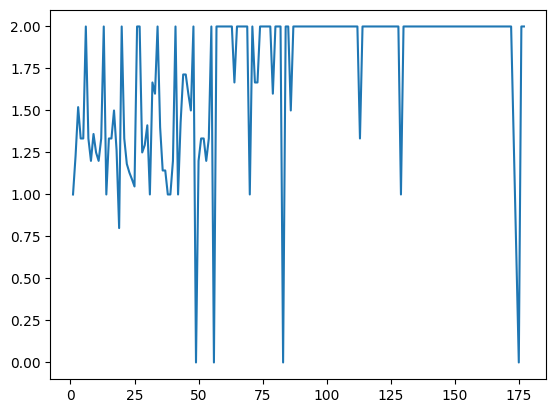

In [270]:
mean_de = {k: np.mean(dir_errors[k]) for k in dir_errors}
mean_de = dict(sorted(mean_de.items()))

plt.plot(list(mean_de.keys()), list(mean_de.values()) )

In [261]:
dfs

[                  contract underlying  expiration  type  strike style   bid  \
 403512  SPY130628P00108000        SPY  2013-06-28   put   108.0     A  0.52   
 403526  SPY130628P00115000        SPY  2013-06-28   put   115.0     A  0.85   
 403528  SPY130628P00116000        SPY  2013-06-28   put   116.0     A  0.90   
 403532  SPY130628P00118000        SPY  2013-06-28   put   118.0     A  1.04   
 403544  SPY130628P00124000        SPY  2013-06-28   put   124.0     A  1.57   
 403546  SPY130628P00125000        SPY  2013-06-28   put   125.0     A  1.69   
 403548  SPY130628P00126000        SPY  2013-06-28   put   126.0     A  1.81   
 403550  SPY130628P00127000        SPY  2013-06-28   put   127.0     A  1.94   
 403552  SPY130628P00128000        SPY  2013-06-28   put   128.0     A  2.08   
 403554  SPY130628P00129000        SPY  2013-06-28   put   129.0     A  2.22   
 403556  SPY130628P00130000        SPY  2013-06-28   put   130.0     A  2.38   
 403558  SPY130628P00131000        SPY  

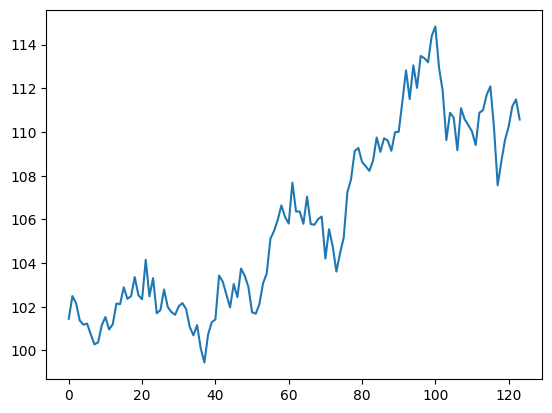

In [278]:
plt.plot(s_df['close'].values)

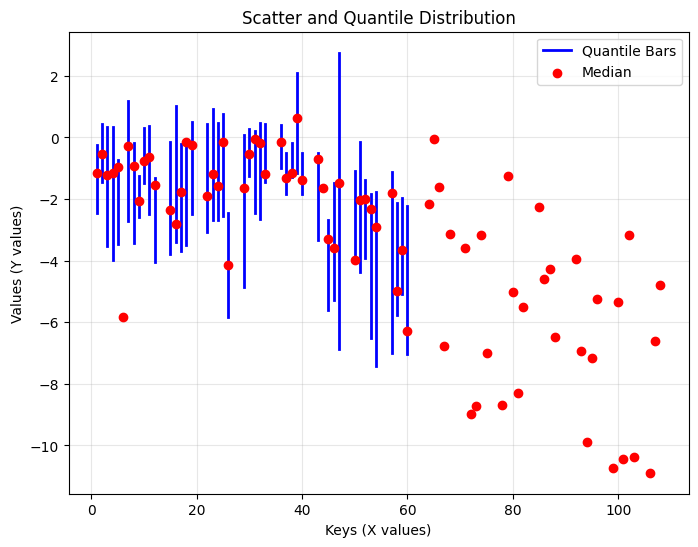

In [274]:
# Prepare the plot
plt.figure(figsize=(8, 6))

# Loop through the dictionary and plot data
for x, values in pred_errors.items():
    # Scatter plot for individual points
    #plt.scatter([x] * len(values), values, alpha=0.7, label=f'Scatter x={x}' if x == 1 else "")
    
    # Compute quantiles
    q25, q50, q75 = np.percentile(values, [25, 50, 75])
    
    # Plot quantile bars
    plt.plot([x, x], [q25, q75], color='blue', linewidth=2)  # Bar for Q25 to Q75
    plt.scatter([x], [q50], color='red', zorder=5)           # Mark the median (Q50)

# Customize the plot
plt.xlabel('Keys (X values)')
plt.ylabel('Values (Y values)')
plt.title('Scatter and Quantile Distribution')
plt.legend(['Quantile Bars', 'Median'], loc='upper right')
plt.grid(True, alpha=0.3)

# Show the plot
plt.show()

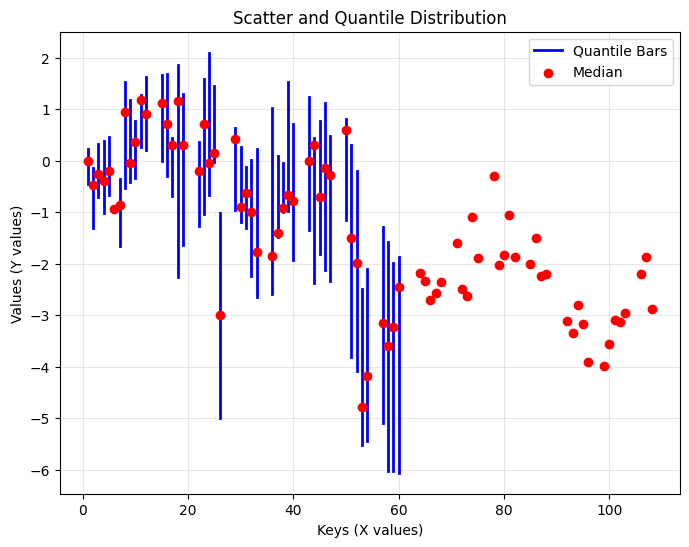

In [275]:
# Prepare the plot
plt.figure(figsize=(8, 6))

# Loop through the dictionary and plot data
for x, values in naive_errors.items():
    # Scatter plot for individual points
    #plt.scatter([x] * len(values), values, alpha=0.7, label=f'Scatter x={x}' if x == 1 else "")
    
    # Compute quantiles
    q25, q50, q75 = np.percentile(values, [25, 50, 75])
    
    # Plot quantile bars
    plt.plot([x, x], [q25, q75], color='blue', linewidth=2)  # Bar for Q25 to Q75
    plt.scatter([x], [q50], color='red', zorder=5)           # Mark the median (Q50)

# Customize the plot
plt.xlabel('Keys (X values)')
plt.ylabel('Values (Y values)')
plt.title('Scatter and Quantile Distribution')
plt.legend(['Quantile Bars', 'Median'], loc='upper right')
plt.grid(True, alpha=0.3)

# Show the plot
plt.show()

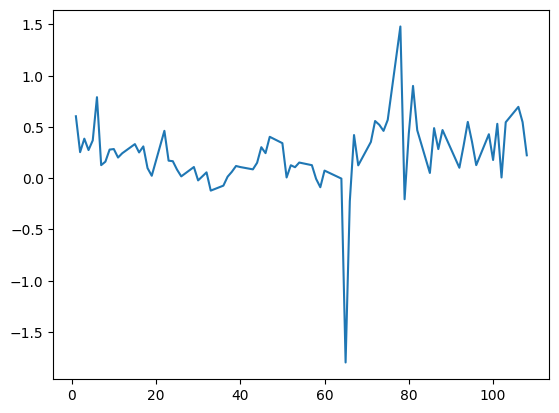

In [277]:
#weight = volume * open_interest --- exclude_itm_options = False
mase = {k: np.mean(np.abs(pred_errors[k]))/np.mean(np.abs(naive_errors[k])) for k in pred_errors}
mase = dict(sorted(mase.items()))

plt.plot(list(mase.keys()), np.log10(list(mase.values())) )

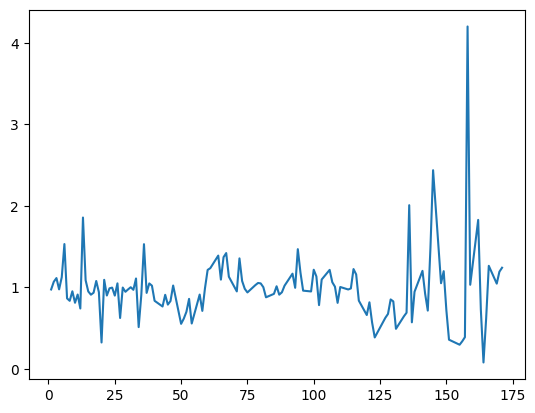

In [233]:
# median
#weight = volume * open_interest --- exclude_itm_options = False
mase = {k: np.mean(np.abs(pred_errors[k]))/np.mean(np.abs(naive_errors[k])) for k in pred_errors}
mase = dict(sorted(mase.items()))

plt.plot(list(mase.keys()), list(mase.values()) )

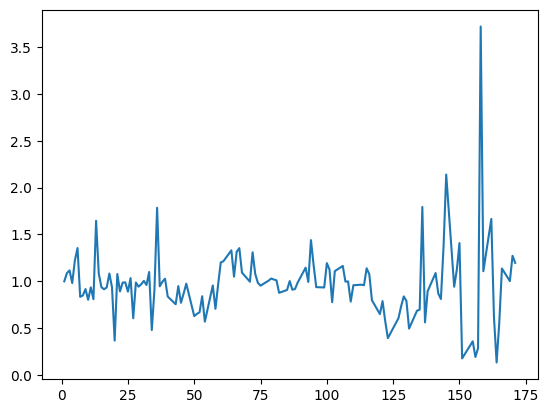

In [231]:
#weight = volume * open_interest --- exclude_itm_options = False
mase = {k: np.mean(np.abs(pred_errors[k]))/np.mean(np.abs(naive_errors[k])) for k in pred_errors}
mase = dict(sorted(mase.items()))

plt.plot(list(mase.keys()), list(mase.values()) )

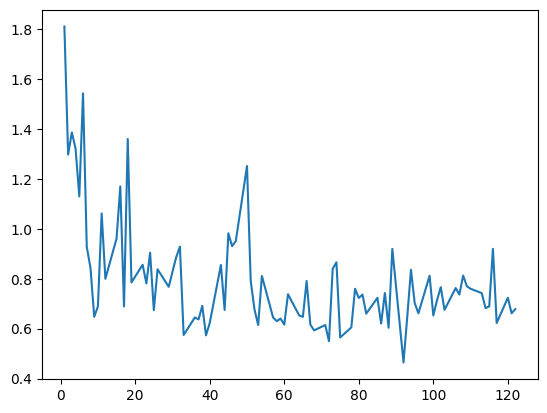

In [214]:
# weight = volume  --- exclude_itm_options = True

mase = {k: np.mean(np.abs(pred_errors[k]))/np.mean(np.abs(naive_errors[k])) for k in pred_errors}
mase = dict(sorted(mase.items()))

plt.plot(list(mase.keys()), list(mase.values()) )

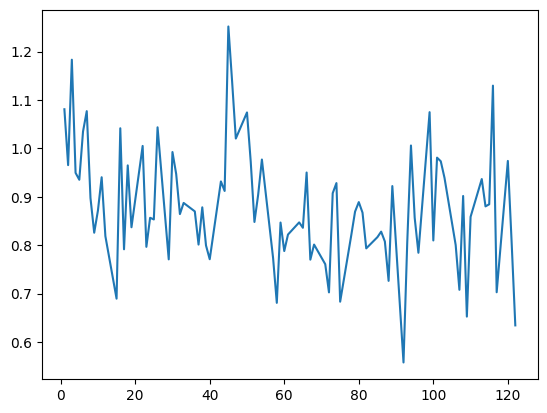

In [212]:
# weight = volume  --- exclude_itm_options = False

mase = {k: np.mean(np.abs(pred_errors[k]))/np.mean(np.abs(naive_errors[k])) for k in pred_errors}
mase = dict(sorted(mase.items()))

plt.plot(list(mase.keys()), list(mase.values()) )

In [207]:
dict(sorted(pred_errors.items()))

{1: [2.2971440110882986,
  -1.0662073804690855,
  0.27835581497568274,
  -0.9350260475199128,
  -1.3816562312958665,
  -0.3309900435506203,
  0.04635445970463766,
  -0.4867893709370719,
  0.09635629060707462,
  0.2734718792457918,
  0.14047917801925772,
  -0.9695081277283758,
  -1.7822883427761866,
  -0.4678465314500836,
  0.7587262644976561,
  0.0478474437581896,
  -1.1785410295576697,
  -1.263054092557412,
  -0.5393045279461766,
  -0.05835073481535785,
  -0.3264880039279414,
  0.7868237114132801,
  0.6929843873899265,
  1.8268858829994377,
  -0.18889121794610456,
  0.3719898578937266],
 2: [3.3489847575978207,
  -0.021586772024820056,
  0.4417886169544743,
  -1.0168948183734126,
  0.07879970219980449,
  0.12247805501162638,
  0.35038277953709185,
  0.6602665360938356,
  -0.003162227722219578,
  0.7523196383097159,
  0.5491217559078503,
  -0.22001173426464643,
  -1.8621536943083081,
  -0.25389095420962465,
  3.113780868837868,
  -2.8514521454662916,
  -2.740195180024243,
  -2.23114069

In [208]:
mase = {k: np.mean(np.abs(pred_errors[k]))/np.mean(np.abs(naive_errors[k])) for k in pred_errors}
mase = dict(sorted(mase.items()))
mase

{1: 1.1255313855507332,
 2: 1.0117656481047013,
 3: 1.1869732089186562,
 4: 1.0769664954633489,
 5: 0.8942069728774262,
 6: 0.971583446319949,
 7: 0.902834496487158,
 8: 0.8628558417307465,
 9: 0.8109902780886211,
 10: 0.9204958318071589,
 11: 0.9417491250594192,
 12: 0.7535354753307901,
 15: 0.8214331706887061,
 16: 0.9312742323842895,
 17: 0.8391159149417396,
 18: 0.9581716390016772,
 19: 0.8212757162474602,
 22: 0.9329916578377498,
 23: 0.7919348090454034,
 24: 0.8422483464503612,
 25: 0.8807630437748925,
 26: 0.8589967244614775,
 29: 0.7789243536676858,
 30: 0.7568428567939536,
 31: 0.9181569799336757,
 32: 0.8858870494089717,
 33: 0.7369947214183826,
 36: 0.7451614362078801,
 37: 0.6835820838065837,
 38: 0.7108278585893999,
 39: 0.6446494320897764,
 40: 0.675265845699523,
 43: 0.7647373468570645,
 44: 0.6556030158114182,
 45: 0.9483969706850115,
 46: 0.8125660863062809,
 47: 0.9397983308638959,
 50: 1.1791566216273572,
 51: 0.8197102342611134,
 52: 0.6805769647720411,
 53: 0.67268

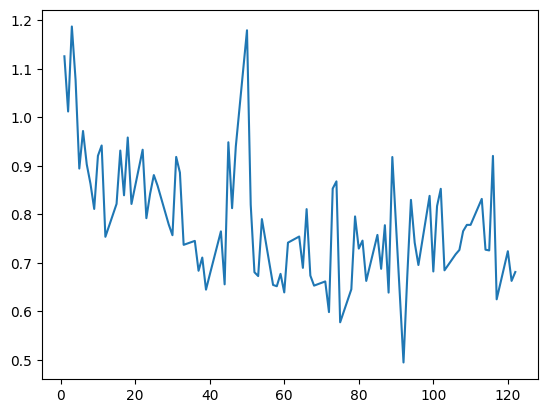

In [210]:
#weight = volume * open_interest --- exclude_itm_options = False
plt.plot(list(mase.keys()), list(mase.values()) )

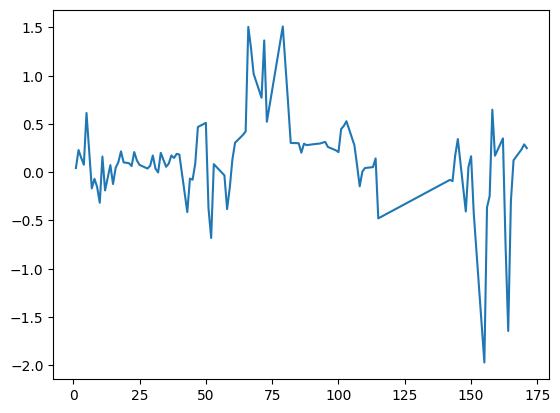

In [181]:
mase.pop(80)
plt.plot(list(mase.keys()), np.log10(list(mase.values())) )

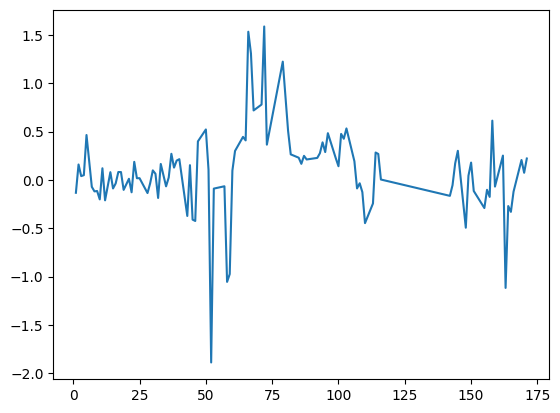

In [177]:
mase.pop(80)
plt.plot(list(mase.keys()), np.log10(list(mase.values())) )

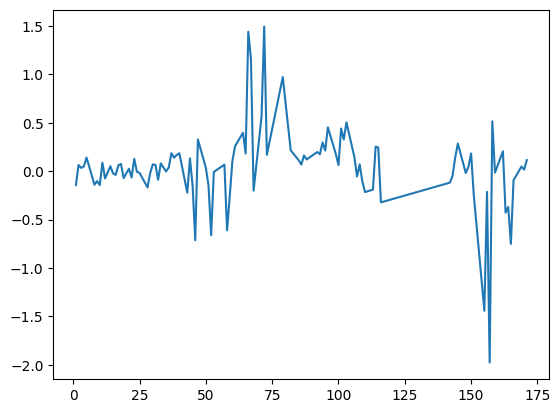

In [173]:
mase.pop(80)
plt.plot(list(mase.keys()), np.log10(list(mase.values())) )

In [ ]:
pred_error = 100.*(pred - s_df.loc[ref_date]['close'])/s_df.loc[ref_date]['close']
naive_error = 100.*(current_asset_price - s_df.loc[ref_date]['close'])/s_df.loc[ref_date]['close']
rel_error = pred_error / naive_error

In [118]:
s_df.loc['2013-01-02']

symbol                 F
open               13.23
high               13.28
low                 13.0
close               13.2
volume          75274700
adjust_close         NaN
Name: 2013-01-02, dtype: object

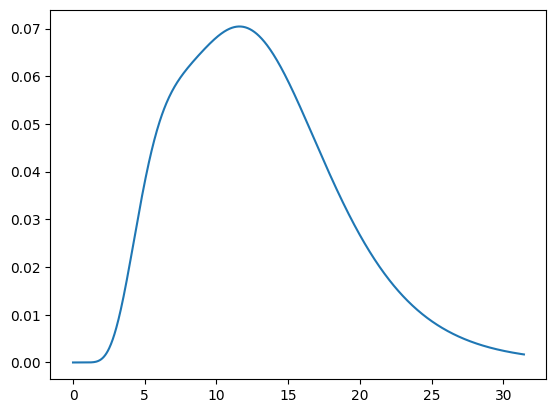

In [108]:
pdf = lambda x: ln_mixture_pdf(x, implied_price_stats.params)
grid = np.linspace(0, 1.2*implied_price_stats.upper_95CI,1000)
pdf_vals = pdf(grid)

plt.plot(grid,pdf_vals)

In [57]:
s_df['close'].values[0]

549.029976

In [94]:
df = pd.concat(dfs).reset_index(drop=True)
display(df)

,contract,underlying,expiration,type,strike,style,bid,bid_size,ask,ask_size,...,delta,gamma,theta,vega,impliedVolatility,breakeven,weight,mu,sigma_ln,mu_ln
0,MSFT150117C00018000,MSFT,2015-01-17,call,18.0,A,9.40,NaN,9.80,NaN,...,0.9511,0.0128,-0.2464,3.9934,0.2011,27.80,0.002184,27.80,3.881282,-4.207139
1,MSFT150117P00018000,MSFT,2015-01-17,put,18.0,A,1.07,NaN,1.11,NaN,...,-0.1284,0.0156,-0.6793,8.2731,0.3418,16.89,0.019659,16.89,6.596829,-18.932352
2,MSFT150117C00020000,MSFT,2015-01-17,call,20.0,A,7.90,NaN,8.10,NaN,...,0.9264,0.0204,-0.2878,5.5025,0.1738,28.10,0.011359,28.10,3.354385,-2.290180
3,MSFT150117P00020000,MSFT,2015-01-17,put,20.0,A,1.54,NaN,1.58,NaN,...,-0.1753,0.0198,-0.8046,10.1780,0.3302,18.42,0.110965,18.42,6.372946,-17.393780
4,MSFT150117C00023000,MSFT,2015-01-17,call,23.0,A,5.70,NaN,5.85,NaN,...,0.7947,0.0373,-0.5811,11.2152,0.1935,28.85,0.002184,28.85,3.734600,-3.611509
5,MSFT150117P00023000,MSFT,2015-01-17,put,23.0,A,2.48,NaN,2.58,NaN,...,-0.2598,0.0259,-0.9672,12.7895,0.3178,20.42,0.043687,20.42,6.133622,-15.794147
6,MSFT150117C00025000,MSFT,2015-01-17,call,25.0,A,4.50,NaN,4.60,NaN,...,0.6966,0.0446,-0.7164,13.7826,0.1988,29.60,0.006116,29.60,3.836892,-3.973094
7,MSFT150117P00025000,MSFT,2015-01-17,put,25.0,A,3.30,NaN,3.45,NaN,...,-0.3227,0.0291,-1.0479,14.1535,0.3127,21.55,0.045435,21.55,6.035191,-15.141389
8,MSFT150117C00028000,MSFT,2015-01-17,call,28.0,A,3.05,NaN,3.15,NaN,...,0.5475,0.0494,-0.8152,15.6235,0.2033,31.15,0.006116,31.15,3.923743,-4.259064
9,MSFT150117P00028000,MSFT,2015-01-17,put,28.0,A,4.90,NaN,5.00,NaN,...,-0.4193,0.0320,-1.1183,15.4117,0.3091,23.00,0.000437,23.00,5.965710,-14.659354


In [49]:
df['expiration'].unique()

array(['2013-01-04', '2013-01-11', '2013-01-19', '2013-01-25',
       '2013-02-01', '2013-02-16', '2013-03-16', '2013-04-20',
       '2013-06-22', '2013-07-20', '2013-10-19', '2014-01-18',
       '2015-01-17'], dtype=object)

In [51]:
df['quote_date'].iloc[0]

'2013-01-02'

In [33]:
quote_dates = df['quote_date'].unique()
quote_dates

array(['2013-01-02'], dtype=object)

In [22]:
pd.options.display.max_rows = 100  # Set it globally in the session

df.tail(500)

,contract,underlying,expiration,type,strike,style,bid,bid_size,ask,ask_size,volume,open_interest,quote_date,delta,gamma,theta,vega,implied_volatility
33289,AAPL130720P00420000,AAPL,2013-07-20,put,420.0,A,10.45,NaN,11.10,NaN,14,217,2013-01-02,-0.1304,0.0015,-29.0954,85.5965,0.3603
33290,AAPL130720P00430000,AAPL,2013-07-20,put,430.0,A,12.15,NaN,12.85,NaN,30,366,2013-01-02,-0.1482,0.0016,-31.4404,93.3619,0.3565
33291,AAPL130720P00435000,AAPL,2013-07-20,put,435.0,A,13.25,NaN,13.80,NaN,8,158,2013-01-02,-0.1580,0.0017,-32.7410,97.4360,0.3555
33292,AAPL130720C00440000,AAPL,2013-07-20,call,440.0,A,119.55,NaN,121.15,NaN,20,98,2013-01-02,0.8244,0.0017,-27.9995,101.4830,0.3545
33293,AAPL130720P00440000,AAPL,2013-07-20,put,440.0,A,14.35,NaN,14.85,NaN,3,196,2013-01-02,-0.1682,0.0017,-34.0112,101.4640,0.3544
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33784,AAPL150117C00900000,AAPL,2015-01-17,call,900.0,A,22.55,NaN,23.80,NaN,47,1334,2013-01-02,0.1944,0.0010,-16.1901,213.0290,0.3374
33785,AAPL150117C00950000,AAPL,2015-01-17,call,950.0,A,17.90,NaN,19.40,NaN,4,647,2013-01-02,0.1631,0.0009,-14.4943,190.9507,0.3352
33786,AAPL150117P00950000,AAPL,2015-01-17,put,950.0,A,430.55,NaN,433.80,NaN,1,53,2013-01-02,-0.8000,0.0009,-20.5497,194.8359,0.3402
33787,AAPL150117C01000000,AAPL,2015-01-17,call,1000.0,A,14.55,NaN,16.65,NaN,130,1728,2013-01-02,0.1400,0.0008,-13.2385,172.7172,0.3369
